In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import argparse
import random
from collections import OrderedDict

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from utils_train import *

In [3]:
load_path = "/users/riya/race/dataset/segmentations/"

In [ ]:
nonzero_dict_train = make_nonzero_dict('train')

In [ ]:
nonzero_dict_train

In [ ]:
nonzero_dict_all = make_nonzero_dict('4546_set')

In [ ]:
nonzero_dict_all

## Testing Median Nonzero Pixel Count While Training

**Old, Incorrect Code**

Basically, we didn't realize this would never include image transforms.

``` python

train_folder = os.path.join('/users/riya/race/classifier_experiments/CNN_train/dataset_full', 'train')
train_dataset = datasets.ImageFolder(train_folder)

black_non_zero = [0]
white_non_zero = [0]

for i, _ in train_dataset.samples:
    run_img = np.array(Image.open(i))
    num_nonzero = np.count_nonzero(run_img)
    if 'black' in i:
        black_non_zero = np.append(black_non_zero, num_nonzero)
    elif 'white' in i:
        white_non_zero = np.append(white_non_zero, num_nonzero)

black_non_zero = black_non_zero[1:]
white_non_zero = white_non_zero[1:]

```

In [ ]:
train_folder = os.path.join('/users/riya/race/classifier_experiments/CNN_train/dataset_full', 'train')
train_dataset = datasets.ImageFolder(train_folder)

In [ ]:
tmp = iter(train_dataset)
images,labels = next(tmp)

In [ ]:
images

In [ ]:
images,labels = next(tmp)

In [ ]:
np.count_nonzero(np.array(images))/3

In [ ]:
len(np.array(images))

In [ ]:
len(train_dataset.samples)

In [ ]:
50176/3

In [ ]:
black_non_zero = [0]
white_non_zero = [0]

tmp = iter(train_dataset)
num_iterations = len(train_dataset.samples)

for i in range(num_iterations):
    image, label = next(tmp)   
    run_img = np.array(image)
    num_nonzero = int(np.count_nonzero(run_img)/3)
    
    if label == 0:
        black_non_zero = np.append(black_non_zero, num_nonzero)
    elif label == 1:
        white_non_zero = np.append(white_non_zero, num_nonzero)

black_non_zero = black_non_zero[1:]
white_non_zero = white_non_zero[1:]

## Testing Final Code For Median Normalizing

In [ ]:
test_img = channeled_image_from_id(load_path, '30672.bmp', (224, 224))

In [ ]:
return_img = average_pixel_count(test_img, 'white', make_nonzero_dict())

In [ ]:
return_arr = np.array(return_img)[:,:,0]

In [ ]:
plt.imshow(return_arr, cmap = 'gray')

In [ ]:
return_arr.shape

In [ ]:
pd.value_counts(return_arr.flatten()) # only one image channel!

In [ ]:
2649 + 1386

Let's test this for all black/white images and see if normalization works. Keep in mind that dictionary values are for three duplicate channels.

In [ ]:
def testing_pixel_averaging(dataset_path, dataset_csv_path,
                           image_size = (224, 224)):
    
    dataset_csv = pd.read_csv(dataset_csv_path)
    if 'train' in dataset_path: # just checking for train set
        files_available = os.listdir(dataset_path + "white") + os.listdir(dataset_path + "black")
        dataset_csv = dataset_csv[dataset_csv['segmentation_location'].isin(files_available)]
        dataset_csv = dataset_csv.reset_index(drop=True)
    
    nonzero_dict = make_nonzero_dict()
    number_of_pixels = number_of_pixels = nonzero_dict['skeletonized_white'] - nonzero_dict['skeletonized_black'] # skeleton images
    number_of_pixels = int(abs(number_of_pixels))
    # nonzero dict contains information for 1 channel, so no division.
    
    num_black = len(dataset_csv[dataset_csv['race'] == 'black'])
    num_white = len(dataset_csv[dataset_csv['race'] == 'white'])
    
    black_pixel_count = np.empty((0, num_black), int)
    white_pixel_count = np.empty((0, num_white), int)

    for i in tqdm(range(len(dataset_csv))):
        
        img_path = f"{dataset_csv['race'][i]}/{dataset_csv['segmentation_location'][i]}"   
        img_run = channeled_image_from_id(dataset_path, img_path, image_size) # image size
  
        if dataset_csv['race'][i] == 'black':
            black_img = average_pixel_count(img_run, 'black', number_of_pixels)           
            black_count = int(np.count_nonzero(black_img)/3) # done for 1 channel
            black_pixel_count = np.append(black_pixel_count, black_count)
            
            # plt.imshow(black_img)
            # plt.show()
            # print (black_count, dataset_csv['image_id'][i])
        
        elif dataset_csv['race'][i] == 'white':
            white_img = average_pixel_count(img_run, 'white', number_of_pixels)
            white_count = int(np.count_nonzero(white_img)/3)
            white_pixel_count = np.append(white_pixel_count, white_count)
            
            # plt.imshow(white_img)
            # plt.show()
            # print (white_count, dataset_csv['image_id'][i])

    return black_pixel_count, white_pixel_count

# black count and white count will end up being for three channels?

In [ ]:
dataset_path = "/users/riya/race/classifier_experiments/CNN_train/dataset_full/train/"
dataset_csv_path = "/users/riya/race/csv/image_race_data.csv"

In [ ]:
black_pixel_count, white_pixel_count = testing_pixel_averaging(dataset_path, dataset_csv_path)

In [ ]:
len(black_pixel_count), len(white_pixel_count)

In [ ]:
nonzero_dict = make_nonzero_dict('train')
nonzero_dict

In [ ]:
np.median(black_pixel_count), np.median(white_pixel_count)

In [ ]:
skel_count = pd.read_csv("/users/riya/race/classifier_experiments/nonzero_count/final_skeletonized_nonzero_count_above_0.csv")

In [ ]:
data_csv_path = "/users/riya/race/csv/image_race_data.csv"  
race_data, checksum_dict = checksum(data_csv_path)

In [ ]:
checksum_dict

In [ ]:
dataset_path = "/users/riya/race/dataset/segmentations/"
img_path = "30672.bmp"

channels = channeled_image_from_id(dataset_path, img_path, (480, 640))

Cv2. Resize is (width, height), which is unusual!!! Works fine for (224, 224) because height and width are the same lol.

In [ ]:
plt.imshow(channels)

In [ ]:
determine_image_race(channels, race_data, checksum_dict)

## Method 3: Normalizing Number of Nonzero Pixels By Removing Small VESSELS from White Images

The idea here is to explore using openCV connected components to try to remove smaller vessels generally (interconnected components) with the goal of achieving an exact equal number of nonzero pixels for black and white images. We'll try to only remove from white images, and hopefully we can get an exact number without having to remove some from black images.

### Testing openCV Connected Components

In [4]:
# we've got to pass in argpare cmd argument
ap = argparse.ArgumentParser()

In [5]:
ap.add_argument("-c", "--connectivity", type=int, default=4,
                help="connectivity for connected component analysis")

_StoreAction(option_strings=['-c', '--connectivity'], dest='connectivity', nargs=None, const=None, default=4, type=<class 'int'>, choices=None, help='connectivity for connected component analysis', metavar=None)

In [6]:
args, unknown = ap.parse_known_args()

In [7]:
img_cv = cv2.imread(load_path + "7571.bmp") # made into three channels (480, 640, 3)
img_cv_skel, img_cv_channel, cv_skel_channel = process_skeletonize(img_cv, True, (224, 224)) # (224, 224)
img_cv_thresh = cv2.threshold(cv_skel_channel, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] # (224, 224)

In [8]:
img_cv_thresh.shape

(224, 224)

In [9]:
img_view = Image.fromarray(img_cv)
img_thresh_view = Image.fromarray(img_cv_thresh)

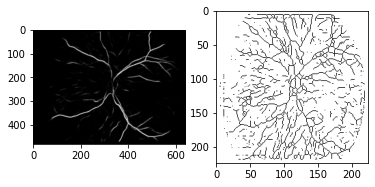

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_view)
ax[1].imshow(img_thresh_view, cmap = 'gray')

# thresh might not work here... let's try 

In [11]:
np.count_nonzero(img_cv_channel), np.count_nonzero(cv_skel_channel), np.count_nonzero(img_cv_thresh) # hmm lots of extra pixels?
# Let's try without thresh possibly

(14641, 4444, 45732)

In [12]:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(cv_skel_channel, cv2.CV_32S, connectivity=4)

In [13]:
numLabels # 1941 WAY better than 97?? Not thresholding is much better

# thresholding gets some larger vessels, but they seem off (and we only need smaller vessels anyway)

1941

In [14]:
# loop over the number of unique connected component labels
output_arr = [0] * numLabels
area_info = [0] * numLabels

for i in range(0, numLabels):
    # 0 is the background
    if i == 0:
        text = f"examining component {i+1}/{numLabels} (background)"
    # otherwise, we are examining an actual connected component
    else:
        text = f"examining component {i+1}/{numLabels}"
    # print a status message update for the current connected
    # component
    print(f"[INFO] {text}")
    # extract the connected component statistics and centroid for
    # the current label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    
    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output = np.array(cv_skel_channel.copy())
    # print(output)
    cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (255, 0, 0), -1)
    
    output_arr[i] = output
    area_info[i] = area
    
    # develop an output "mask" that stores all vessels we are removing (we'll then subtract it) to remove pixel count
    # assert np.count_nonzero(mask) == (nonzero_dict info)
    

[INFO] examining component 1/1941 (background)
[INFO] examining component 2/1941
[INFO] examining component 3/1941
[INFO] examining component 4/1941
[INFO] examining component 5/1941
[INFO] examining component 6/1941
[INFO] examining component 7/1941
[INFO] examining component 8/1941
[INFO] examining component 9/1941
[INFO] examining component 10/1941
[INFO] examining component 11/1941
[INFO] examining component 12/1941
[INFO] examining component 13/1941
[INFO] examining component 14/1941
[INFO] examining component 15/1941
[INFO] examining component 16/1941
[INFO] examining component 17/1941
[INFO] examining component 18/1941
[INFO] examining component 19/1941
[INFO] examining component 20/1941
[INFO] examining component 21/1941
[INFO] examining component 22/1941
[INFO] examining component 23/1941
[INFO] examining component 24/1941
[INFO] examining component 25/1941
[INFO] examining component 26/1941
[INFO] examining component 27/1941
[INFO] examining component 28/1941
[INFO] examining

[INFO] examining component 1150/1941
[INFO] examining component 1151/1941
[INFO] examining component 1152/1941
[INFO] examining component 1153/1941
[INFO] examining component 1154/1941
[INFO] examining component 1155/1941
[INFO] examining component 1156/1941
[INFO] examining component 1157/1941
[INFO] examining component 1158/1941
[INFO] examining component 1159/1941
[INFO] examining component 1160/1941
[INFO] examining component 1161/1941
[INFO] examining component 1162/1941
[INFO] examining component 1163/1941
[INFO] examining component 1164/1941
[INFO] examining component 1165/1941
[INFO] examining component 1166/1941
[INFO] examining component 1167/1941
[INFO] examining component 1168/1941
[INFO] examining component 1169/1941
[INFO] examining component 1170/1941
[INFO] examining component 1171/1941
[INFO] examining component 1172/1941
[INFO] examining component 1173/1941
[INFO] examining component 1174/1941
[INFO] examining component 1175/1941
[INFO] examining component 1176/1941
[

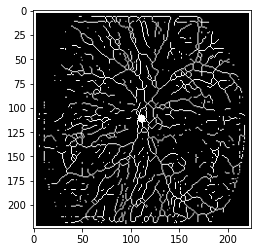

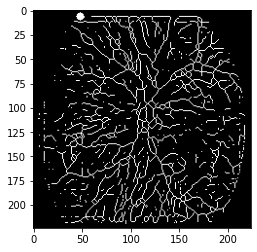

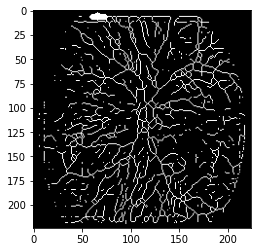

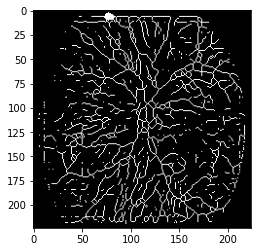

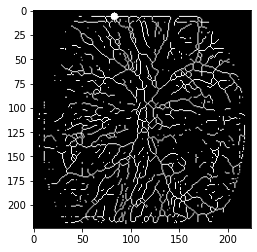

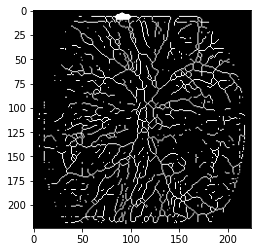

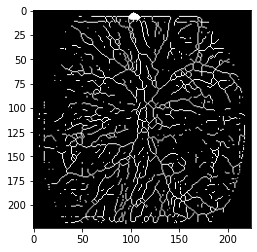

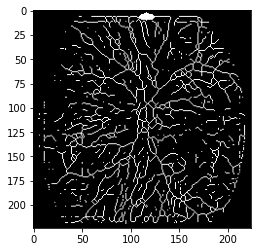

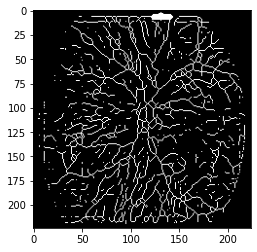

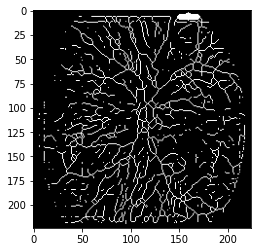

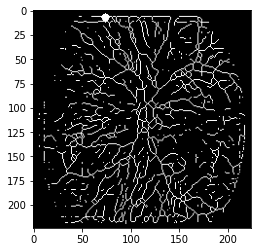

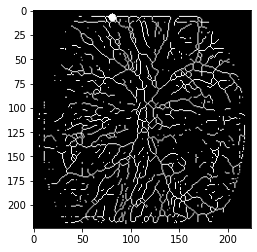

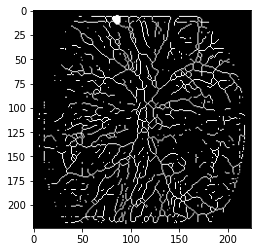

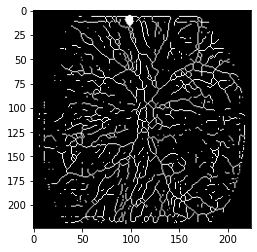

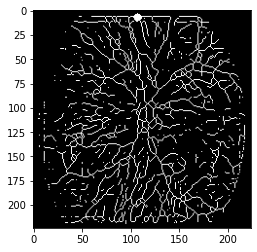

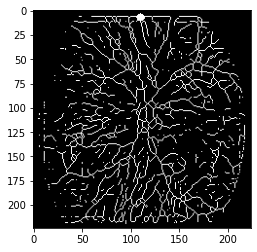

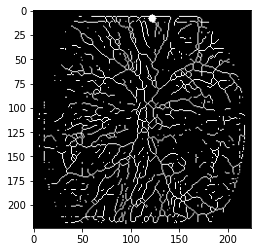

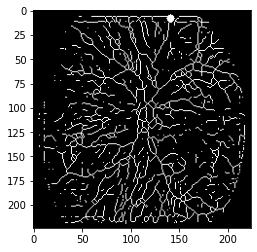

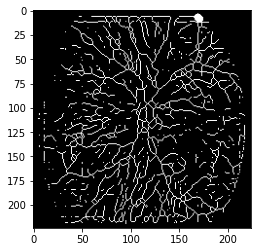

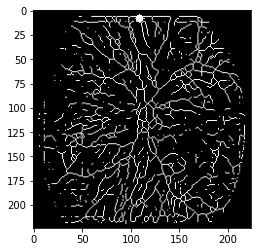

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [15]:
for i in output_arr:
    i = np.stack([i, i, i], axis = 2)
    # print(i.shape)
    plt.imshow(i)
    plt.show()

In [15]:
area_info

[45732,
 3,
 14,
 6,
 3,
 12,
 7,
 11,
 18,
 19,
 2,
 2,
 6,
 7,
 2,
 1,
 3,
 3,
 5,
 1,
 1,
 2,
 1,
 4,
 1,
 3,
 1,
 1,
 16,
 2,
 1,
 1,
 3,
 3,
 1,
 4,
 3,
 7,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 6,
 1,
 1,
 6,
 12,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 2,
 6,
 1,
 4,
 10,
 2,
 4,
 7,
 4,
 3,
 8,
 4,
 2,
 1,
 4,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 6,
 4,
 1,
 1,
 8,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 6,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 7,
 7,
 1,
 2,
 1,
 2,
 2,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 5,
 2,
 12,
 2,
 7,
 4,
 3,
 6,
 4,
 1,
 2,
 6,
 13,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 5,
 2,
 2,
 2,
 2,
 8,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 8,
 1,
 2,
 1,
 2,
 1,
 3,
 6,
 7,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 5,
 5,
 5,
 1,
 5,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 5,
 3,
 1,
 1,
 10,
 1,
 5,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 8,
 

In [16]:
area_dict = dict(pd.value_counts(area_info)) 
# this should be the total area in pixels of the componenent
# so i just need to figure out how to make this into a dictionary
# and then sum up the numbers to the number of pixels (~ 1400) I need to remove
# and perhaps even have to split one of the components

In [17]:
area_dict

{1: 887,
 2: 484,
 3: 257,
 4: 109,
 5: 74,
 6: 55,
 7: 31,
 10: 11,
 8: 10,
 12: 6,
 9: 5,
 11: 3,
 14: 3,
 19: 1,
 13: 1,
 16: 1,
 17: 1,
 18: 1,
 45732: 1}

In [18]:
area_sorted_dict = {}

for key in sorted(area_dict.keys()):
    area_sorted_dict[key] = area_dict[key]

In [19]:
area_sorted_dict # in order woo

{1: 887,
 2: 484,
 3: 257,
 4: 109,
 5: 74,
 6: 55,
 7: 31,
 8: 10,
 9: 5,
 10: 11,
 11: 3,
 12: 6,
 13: 1,
 14: 3,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 45732: 1}

In [71]:
def make_removed_components_mask(number_of_pixels, area_sorted_dict): # exists per image
    
    remaining_pixels = number_of_pixels
    
    for i in area_sorted_dict.keys(): # keys in the right sort order
        included_pixels = area_sorted_dict[i] * i 
        remaining_pixels -= included_pixels
            
        if remaining_pixels < 0: # we've reached our i limit
            limit_reached = i
            modulus_pixels = remaining_pixels + included_pixels
            number_vessels = int(np.floor(modulus_pixels/limit_reached))
            vessel_remainder = (modulus_pixels % limit_reached) # remainder, shld be int
            print(limit_reached, number_vessels, vessel_remainder)
            break;
    
    counter = 0
    mask = np.zeros((224, 224)).astype("uint8")
    mask_twos = np.zeros((224, 224)).astype("uint8")

    randint_arr = [0.5] * numLabels # cause there'll never be a decimal label
    test_arr = [0]
    
    for i in range(0, numLabels): # not accounting for vessel fraction just yet
        
        img_index = 0.5
        while img_index in randint_arr: # will always be at first
            img_index = random.randint(0, numLabels-1) # retry man
        
        randint_arr[i] = img_index
 
        # above is inefficient code!
        
        area = stats[img_index, cv2.CC_STAT_AREA]
        
        if area < limit_reached:
            componentMask = (labels == img_index).astype("uint8") * 255
            # print(np.count_nonzero(componentMask))
            mask = cv2.bitwise_or(mask, componentMask)

        elif area == limit_reached:
            if counter < number_vessels:
                test_arr = np.append(test_arr, img_index)
                componentMask = (labels == img_index).astype("uint8") * 255
                mask = cv2.bitwise_or(mask, componentMask)
                counter+=1
            # only happen when all limit reached vessels are gone. 
            # Then adding to counter, so vessel remainder happens only once
            elif counter == number_vessels:
                componentMask = (labels == img_index).astype("uint8") * 255
                num_pixels_remove = np.count_nonzero(componentMask) - vessel_remainder    
                # print(num_pixels_remove)
                a,b = np.nonzero(componentMask) # getting arrays of (a,b) nonzero indices
                # print (a, b)
                # print (a[1], b[1])
                index = np.random.choice(len(a), num_pixels_remove, replace=False)
                # print(index)
                componentMask[a[index], b[index]] = 0
                mask = cv2.bitwise_or(mask, componentMask)
                
                counter+=1; # out of this elif
                
    final_mask = mask

    return final_mask

In [72]:
final_mask = make_removed_components_mask(1386, area_sorted_dict)

2 249 1


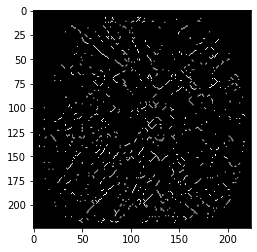

In [73]:
plt.imshow(final_mask, cmap = 'gray')

In [74]:
np.count_nonzero(final_mask)

1386

In [66]:
component_mask, component_mask_twos, vessel_split_mask = make_removed_components_mask(1386, area_sorted_dict)

2 249 1
1
[140 141] [74 74]
141 74
[1]
250


In [67]:
vessel_split_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

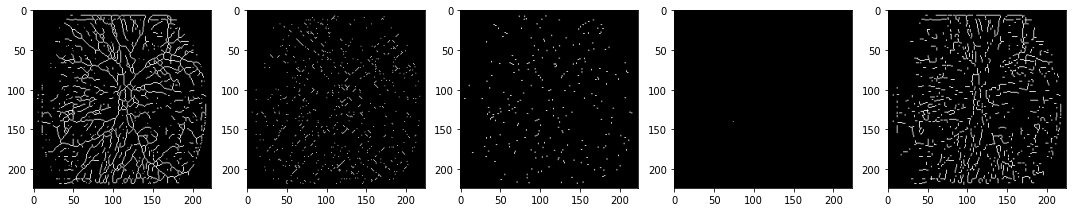

In [68]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18.5, 10.5, forward=True)
ax[0].imshow(cv_skel_channel, cmap = 'gray')
ax[1].imshow(component_mask, cmap = 'gray')
ax[2].imshow(component_mask_twos, cmap = 'gray')
ax[3].imshow(vessel_split_mask, cmap = 'gray')
ax[4].imshow(cv_skel_channel - component_mask - component_mask_twos, cmap = 'gray')


In [70]:
np.count_nonzero(component_mask) + np.count_nonzero(component_mask_twos) + np.count_nonzero(vessel_split_mask)

1386

## Version 2: Normalizing Number of Nonzero Pixels By Removing Small Pixels from White Images

1. get an array of (non skeletonized) image's pixel coordinates (tuple) by intensity value -- ALL coordinates included (exclude coordinates equal to 0)
2. skeletonize image
3. for loop to go through array from first to last element until I have removed the nonzero_adjust number of pixels

In [ ]:
def even_out_pixels2(img, number_of_pixels, # all images 224 x 224
                    image_size = (224, 224)):
    
    # first img numbers by pixel intensity
    
    img, channel, modified_channel = process_skeletonize(img, True, image_size) # yes skeletonize

    pixel_dict = dict(enumerate(channel.flatten(), 1)) # chooses one channel, they will be duplicated
    pixel_dict = {key - 1:val for key, val in pixel_dict.items() if val != 0}
    
    sorted_dict = {}
    sorted_keys = sorted(pixel_dict, key = pixel_dict.get)
    for w in sorted_keys:
        sorted_dict[w] = pixel_dict[w]
      
    # skeletonize img
    img_flatten = channel.flatten()
    skeleton_img_flatten = modified_channel.flatten()
    
    i = 0
    
    for key, value in sorted_dict.items(): # should go in sorted order, from min to max PIV
        assert img_flatten[key] == value # sanity check
        if i < number_of_pixels: # not <= 
            if skeleton_img_flatten[key] != 0: # pixel hasn't been removed in skeletonization
                skeleton_img_flatten[key] = 0 # for white images, removing pixels
                i+=1
    
    final_img = skeleton_img_flatten.reshape(image_size)
    return modified_channel, final_img

In [ ]:
test_img = channeled_image_from_id(load_path, '33349.bmp', (224, 224))
test_img.shape

In [ ]:
plt.imshow(test_img, cmap = 'gray')

In [ ]:
number_of_pixels = 1400 # my approximation

In [ ]:
skeleton_original, final_image = average_pixel_count(test_img, 'white', number_of_pixels)

In [ ]:
plt.imshow(skeleton_original, cmap = 'gray')

In [ ]:
pd.value_counts(skeleton_original.flatten())

In [ ]:
skeleton_original.shape

In [ ]:
np.count_nonzero(skeleton_original)

In [ ]:
plt.imshow(final_image, cmap = 'gray')

In [ ]:
np.count_nonzero(np.array(final_image)[:,:,0])

In [ ]:
3216 + 1400

In [ ]:
3863 - 1400

In [ ]:
img_og, channel, modified_channel = process_skeletonize(test_img, True, (224, 224))

In [ ]:
plt.imshow(channel, cmap = 'gray')

In [ ]:
plt.imshow(modified_channel, cmap = 'gray')

### Testing Dictionary Modifications

In [ ]:
img3 = np.array(Image.open(load_path + "7571.bmp"))

In [ ]:
1 + 480 * 639

In [ ]:
306721/480

In [ ]:
img3[0]

In [ ]:
img3.shape

In [ ]:
pixel_dict = dict(enumerate(img3.flatten(), 1))

In [ ]:
len(pixel_dict)

In [ ]:
pixel_dict2 = {key - 1:val for key, val in pixel_dict.items() if val != 0}

In [ ]:
len(pixel_dict2)

In [ ]:
pixel_dict2

In [ ]:
def key_to_coordinate(key, img_shape):
    
    x_size = img_shape[0]
    y_size = img_shape[1]
    
    if key % x_size != 0: # not  multiple of 480 (x_size)
        x_val = (key % x_size) - 1
        y_val = np.floor(key/x_size)
    elif key % x_size == 0:
        x_val = x_size - 1 # must be in last column
        y_val = np.floor(key/x_size) - 1
    
    coord_tuple = (int(x_val), int(y_val))
    
    return coord_tuple

In [ ]:
pixel_dict3 = {key_to_coordinate(key, (480, 640)):val for key, val in pixel_dict2.items()} # image shape can be diffrt

In [ ]:
len(pixel_dict4)

In [ ]:
pixel_dict3

In [ ]:
pixel_dict2

In [ ]:
sorted_dict = {}

In [ ]:
sorted_keys = sorted(pixel_dict2, key =pixel_dict2.get)
for w in sorted_keys:
    sorted_dict[w] = pixel_dict2[w]

In [ ]:
for key, value in sorted_dict.items():
    print(key, value)

In [ ]:
arr_test = []
for _, values in sorted_dict.items():
    arr_test = np.append(arr_test, values)

In [ ]:
pd.value_counts(arr_test)

### Confirming Image Flattening

In [ ]:
flatten_img = img3.flatten()

In [ ]:
flatten_img.shape

In [ ]:
num_correct = 0
for key, val in pixel_dict2.items():
    if flatten_img[key] != val:
        print ('shite')
    else: num_correct +=1

print (num_correct)

In [ ]:
rebuilt_img = flatten_img.reshape(480, 640)

In [ ]:
plt.imshow(rebuilt_img, cmap = 'gray')

## Version 1: Normalizing Nonzero Pixel Count

In [ ]:
img1 = np.array(Image.open(load_path + "7571.bmp"))

In [ ]:
np.count_nonzero(img1)

In [ ]:
plt.imshow(img1, cmap='gray')

In [ ]:
img1[img1 > 0] = 255

In [ ]:
skeleton_img1 = skeletonize(img1, method='lee')

In [ ]:
np.count_nonzero(skeleton_img1)

In [ ]:
plt.imshow(skeleton_img1, cmap = 'gray')

In [ ]:
img2 = np.array(Image.open(load_path + "101934.bmp"))

In [ ]:
np.count_nonzero(img2)

In [ ]:
plt.imshow(img2, cmap = 'gray')

In [ ]:
img2[img2 > 0] = 255

In [ ]:
skeleton_img2 = skeletonize(img2, method='lee')

In [ ]:
plt.imshow(skeleton_img2, cmap = 'gray')

In [ ]:
np.count_nonzero(skeleton_img2)

In [ ]:
pos_arr = [(3,4), (6,8)]

In [ ]:
2 in pos_arr

In [ ]:
def even_out_pixels(img_input, img_race, number_of_pixels): # Note: number of pixels is a FLOAT
    
    img = np.copy(img_input)

    for_loop_count = int(number_of_pixels)
    
    # print(for_loop_count)
    pos_array = [0] * for_loop_count
    img_pixels = np.count_nonzero(img)
    
    print(img_pixels)

    for i in range(for_loop_count): # while loop
        
        print (i)
        
        # Pick random coordinates
        x_coord=random.randint(0, img.shape[0] - 1)
        y_coord=random.randint(0, img.shape[1] - 1)

        random_pos = (x_coord, y_coord)
        
        # print(random_pos)
        
        if random_pos not in pos_array:
            if img_race == 'black': # add pixels
                if img[random_pos] == 0:
                    img[random_pos] = 255
                    pos_array[i] = random_pos
                elif img[random_pos] == 255:
                    i-=1

            elif img_race == 'white':
                if img[random_pos] == 255:
                    # print(i)
                   #  print ('hmm')
                    img[random_pos] = 0
                    pos_array[i] = random_pos
                elif img[random_pos] == 0:
                    # print('lets see')
                    i-=1
        elif random_pos in pos_array:
            i-=1 # that i didn't count
    
    return img

In [ ]:
number_of_pixels = abs(np.count_nonzero(skeleton_img1) - np.count_nonzero(skeleton_img2))/2 

In [ ]:
number_of_pixels

In [ ]:
pd.value_counts(skeleton_img1[300])

In [ ]:
transformed_img1 = even_out_pixels(skeleton_img1, 'white', number_of_pixels)
transformed_img2 = even_out_pixels(skeleton_img2, 'black', number_of_pixels)

In [ ]:
plt.imshow(transformed_img1, cmap = 'gray')

In [ ]:
np.count_nonzero(transformed_img1)

In [ ]:
plt.imshow(transformed_img2, cmap = 'gray')

In [ ]:
np.count_nonzero(transformed_img2) # mostly working?

In [ ]:
test_predictions = pd.read_csv("/users/riya/race/classifier_experiments/CNN_train/outputs/probabilities/#11(average_pixel_count)/train_test_val_set_normalized_nonzero_pixels_epoch50.csv")

In [ ]:
race_column = [0] * len(test_predictions)

for j in range(len(test_predictions)):

    if (test_predictions['img_loc'][j].find('black') != -1):
        race_column[j] = 0
    elif (test_predictions['img_loc'][j].find('white') != -1):
        race_column[j] = 1

    test_predictions['race'] = race_column

    # return test_predictions

    black_predictions = test_predictions[test_predictions['race'] == 0]        
    white_predictions = test_predictions[test_predictions['race'] == 1]

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test_predictions['race'],  1 - test_predictions['probability'])
auc = metrics.roc_auc_score(test_predictions['race'], 1 - test_predictions['probability'])

In [ ]:
auc

In [ ]:
# Overall Kappa TIME!
kappa_labels = (test_predictions['probability'] < 0.5).astype(int) 
# this gives prob of the black class 
kappa = metrics.cohen_kappa_score(test_predictions['race'], kappa_labels) 
# actual labels, probabilities   
kappa = np.round(kappa, 4) 

In [ ]:
kappa

In [ ]:
def get_acc(true_values, probabilities):
   
    true_values = true_values.reset_index(drop=True)
    probabilities = probabilities.reset_index(drop=True)

    assert len(true_values) == len(probabilities)
    num_elements = len(true_values)
    same_elements = 0
    
    for i in range(num_elements):
        rounded_prob = round(probabilities[i])
        if true_values[i] == rounded_prob:
            same_elements += 1
    
    acc = same_elements/num_elements
    acc = 1 - acc
            
    acc = np.round(acc,4) # 1 - just to get the percent misclassified
    
    return acc

In [ ]:
white_acc = get_acc(white_predictions['race'],  white_predictions['probability']) 
black_acc = get_acc(black_predictions['race'],  black_predictions['probability']) # black class probability

In [ ]:
white_acc, black_acc